# Homework 6, Problem 4 - Particle filter
You will change the observation model (cell 6) and the observation probability (cell 10) to make
this particle filter simulation have Poisson observations instead of Gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats


In [2]:
np.random.seed(0)

In [3]:
# 1-D state dynamics
def state_dynamics(z):
    return z + np.random.randn(*z.shape)

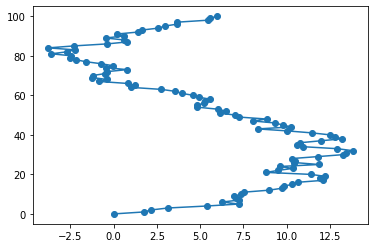

In [4]:
# Generate a random simulation of our latent state dynamics
z = [np.array(0)]
t = [0]
for i in range(100):
    z.append(state_dynamics(z[-1]))
    t.append(i+1)

plt.plot(z,t,'-o')

In [5]:
## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100
PF_Max = 10 # Maximum firing rate
PF_Width = 25 # Width or fall off in space of Place fields

def mean_rate(z):
    return np.exp(-((z - PF_Centers)/PF_Width)**2) * PF_Max

In [6]:
###
### For homework you will change this to Poisson!
###


## For Gaussian model, we need a standard deviation per neuron
Gaussian_PF_Noise_Variance = 10

# Randomly generate an observation from neurons
def observation(z):
    #
    # Additive Gaussian noise. Change this to Poisson!
    #
    return mean_rate(z) + np.random.randn(len(PF_Centers))*np.sqrt(Gaussian_PF_Noise_Variance)

    #return np.random.poisson(lam=mean_rate(z))

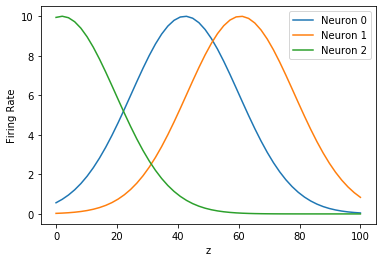

In [7]:
# Plot some example receptive fields
z = np.linspace(0,100)
nn = np.array([mean_rate(z_) for z_ in z])
plt.plot(z,nn[:,0], label='Neuron 0')
plt.plot(z,nn[:,1], label='Neuron 1')
plt.plot(z,nn[:,2], label='Neuron 2')
plt.gca().set_ylabel('Firing Rate')
plt.gca().set_xlabel('z')
plt.legend()

In [8]:
# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)



In [9]:
# Here's the neural activity corresponding to our trajectory

Neural_Activity = np.array([observation(z) for z in Trajectory])



In [10]:

###
### Homework - Modify this to be Poisson!
###


def p_observation(x, z):
    # Quick way of calculating Multivariate normal with uncorrelated dimensions
    # Calculate the product across neurons as exp( sum (log_probabilities) )
    return np.exp(scipy.stats.norm.logpdf(x, mean_rate(z), np.sqrt(Gaussian_PF_Noise_Variance)).sum())

    #return np.exp(scipy.stats.poisson.logpmf(x, mean_rate(z)).sum())


In [11]:
# Run the particle filter

N = 100
Z = []
I = []
Z_ = []
W = []


# Start by sampling initial distribution, N(0,10)
# Generate N particles corresponding to time 0
Z.append(np.random.randn(N)*np.sqrt(10))

### In python Z[-1] refers to the last item in a list or vector

for i in range(101):
    # Calculate a posteriori probability for each particle
    APosterioriProb = np.array([p_observation(Neural_Activity[i,:],z) for z in Z[-1]])
    # Normalize probabilities to get a weight vector
    W.append(APosterioriProb / APosterioriProb.sum())
    # Sample particles using weights - I[] keeps track of the indices chosen
    #  we could do it more efficiently like this:
    #      z_ =  np.random.choice(Z[-1],size=N,replace=True,p=W[-1])
    idx =  np.random.choice(N,size=N,replace=True,p=W[-1])
    I.append(idx)
    z_ = Z[-1][idx]
    Z_.append(z_)
    # Step forward in time by sampling from the dynamics
    Z.append( state_dynamics(z_) )





/home/ckemere/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<StemContainer object of 3 artists>

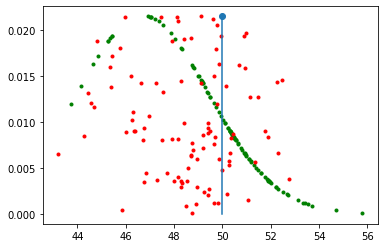

In [12]:
# Plot the distribution of particles at a particular time step
t = 50

pp = np.array([p_observation(Neural_Activity[t,:],z) for z in Z[t]])
pp = pp / pp.sum()
plt.plot(Z[t], pp,'g.')
plt.plot(Z[t+1], pp,'r.')
plt.stem([Trajectory[t]], [np.max(W[t])])


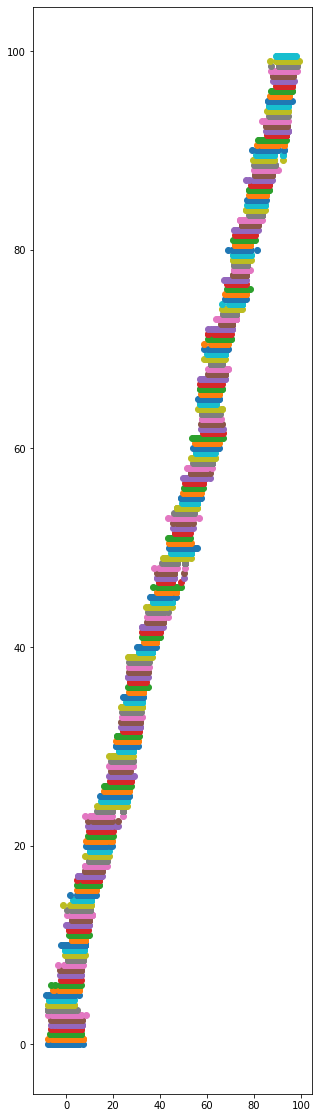

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5,20))
for i in range(100):
    ax.plot(Z[i], i*np.ones(N), 'o')
    ax.plot(Z_[i], i*np.ones(N)+0.5, 'o')

MSE = 14.062837533038788


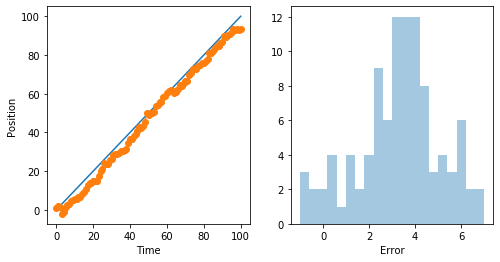

In [14]:
# Calculate estimated trajectory

Z_ = np.array(Z)
W_ = np.array(W)

EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


# Plot estimated trajectory and error histogram
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(Trajectory)
axs[0].plot(EstimatedTrajectory, '-o')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')

Error = (Trajectory - EstimatedTrajectory)

import seaborn as sns
sns.distplot(Error, ax=axs[1], bins=20, kde=False)
axs[1].set_xlabel('Error')
print('MSE = {}'.format(np.mean(Error**2)))

#### Commentary - notice that the error is strongly biased. This is because the animal is moving further 
####   each timestep than would be likely for a N(0,1) random walk. Try changing the "speed" of the animal
####   to 0.5 or 0.1 cm per time step and see if the error is still biased.
